# CMIP6 Compute VPD

**Following steps are included in this script:**

1. Load netCDF files
2. Compute VPD
3. Save and replace netcdf files

In [18]:
# ========== Packages ==========
import xarray as xr
import pandas as pd
import numpy as np
import dask
import os

### Functions

In [19]:
def save_file(save_file, folder, save_var=True):
    """
    Save files as netCDF.

    Args:
        savefile (dict or dataset): Dictionary of xarray datasets or dataset.
        folder (string): Name of folder data is saved in.
        save_var (boolean): If True, data is saved separately for each variable. If false, one file is saved with all variables.
        

    Returns:
        nc_out: Path were data is saved in.
    """
    
    if save_var:
        for key, ds in ds_dict.items():
            for var in ds:
                # Variable to keep
                variable_to_keep = var
                dimensions_to_keep = {'time', 'lat', 'lon'}
                coordinates_to_keep = {'time', 'lat', 'lon'}

                if any('depth' in ds[var].dims for var in ds.variables):
                    dimensions_to_keep.add('depth')
                    coordinates_to_keep.add('depth')

                # Create a new dataset with only the desired variable
                ds_var = ds[[variable_to_keep]]

                # Keep only the desired dimensions
                ds_var = ds_var.isel({dim: slice(None) for dim in dimensions_to_keep.intersection(ds_var.dims)})

                # Set the desired coordinates
                coords_to_set = set(ds_var.variables).intersection(coordinates_to_keep)
                ds_var = ds_var.set_coords(list(coords_to_set))

                savepath = f'../../data/CMIP6/{ds_var.experiment_id}/{folder}/{var}/'
                filename = f'CMIP.{ds_var.source_id}.{ds_var.experiment_id}.{var}_regridded.nc'
                nc_out = os.path.join(savepath, filename)
                os.makedirs(savepath, exist_ok=True) 
                if os.path.exists(nc_out):
                       # inp = input(f"Delete old file {filename} (y/n):")
                       # if inp.lower() in ["y"]:
                            os.remove(nc_out)
                            print(f"File  with path: {nc_out} removed")
                      #  else:
                      #      filename = "temp_file.nc"
                      #      nc_out = os.path.join(savepath, filename)
                      #      print(f"Filename change to {filename}")

                # Save to netcdf file
                with dask.config.set(scheduler='threads'):
                    ds_var.to_netcdf(nc_out)
                    print(f"File with path: {nc_out} saved")
       
    else:
        for key in save_file.keys():
            ds_in = save_file[key]
            filename = f'CMIP.{ds_in.source_id}.{ds_in.experiment_id}_regridded.nc'
            savepath = f'../data/CMIP6/{ds_in.experiment_id}/{folder}'
            nc_out = os.path.join(savepath, filename)
            os.makedirs(savepath, exist_ok=True) 
            if os.path.exists(nc_out):
                inp = input(f"Delete old file {filename} (y/n):")
                if inp.lower() in ["y"]:
                    os.remove(nc_out)
                    print(f"File  with path: {nc_out} removed")
                else:
                    filename = "temp_file.nc"
                    nc_out = os.path.join(savepath, filename)
                    print(f"Filename change to {filename}")

            # Save to netcdf file
            with dask.config.set(scheduler='threads'):
                ds_in.to_netcdf(nc_out)

    return nc_out

### 1. Load netCDF files

In [20]:
# ========= Define period, models and path ==============
variable='ps' #['evspsbl', 'gpp', 'huss', 'lai', 'mrro', 'pr', 'tran', 'lmrso_1m', 'lmrso_2m']
experiment_id = 'ssp370'
source_id = ['TaiESM1', 'BCC-CSM2-MR',  'CanESM5', 'CNRM-CM6-1', 'CNRM-ESM2-1', 'IPSL-CM6A-LR', 'UKESM1-0-LL', 'MPI-ESM1-2-LR', 'CESM2-WACCM', 'NorESM2-MM']
folder='preprocessed'
savepath = f'../../data/CMIP6/{experiment_id}/{folder}/{variable}'

# ========= Use Dask to parallelize computations ==========
dask.config.set(scheduler='processes')

# ========= Create a helper function to open the dataset ========
def open_dataset(filename):
    ds = xr.open_dataset(filename)
    return ds

# ========= Create dictionary using a dictionary comprehension and Dask =======
ds_dict_ps, = dask.compute({model: open_dataset(os.path.join(savepath, f'CMIP.{model}.{experiment_id}.{variable}_regridded.nc'))
                        for model in source_id})

In [21]:
ds_dict = {}
for name, ds in ds_dict_ps.items():
    ds_dict[name] = xr.merge([ds_dict_ps[name], ds_dict_huss[name]])

In [26]:
# ========= Have a look into the dictionary =======
print(list(ds_dict.keys()))
ds_dict[list(ds_dict.keys())[0]]

['TaiESM1', 'BCC-CSM2-MR', 'CanESM5', 'CNRM-CM6-1', 'CNRM-ESM2-1', 'IPSL-CM6A-LR', 'UKESM1-0-LL', 'MPI-ESM1-2-LR', 'CESM2-WACCM', 'NorESM2-MM']


<xarray.Dataset>
Dimensions:  (time: 3012, lat: 149, lon: 360)
Coordinates:
  * time     (time) object 1850-01-16 12:00:00 ... 2100-12-16 12:00:00
  * lat      (lat) int64 -59 -58 -57 -56 -55 -54 -53 ... 83 84 85 86 87 88 89
  * lon      (lon) int64 -180 -179 -178 -177 -176 -175 ... 175 176 177 178 179
Data variables:
    vpd      (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
Attributes: (12/54)
    product:                   model-output
    branch_time_in_child:      0.0
    Conventions:               CF-1.7 CMIP-6.2
    experiment_id:             ssp370
    variant_label:             r1i1p1f1
    title:                     TaiESM1 output prepared for CMIP6
    ...                        ...
    parent_sub_experiment_id:  none
    further_info_url:          https://furtherinfo.es-doc.org/CMIP6.AS-RCEC.T...
    model_id:                  TaiESM1
    intake_esm_dataset_key:    ScenarioMIP.AS-RCEC.TaiESM1.ssp370.Amon.gn
    log:                       Dataset sliced along lat 60 to remove Antartic...
    regrid_method:             conservative

### 2. Compute VPD

In [23]:
for i, (name, ds) in enumerate(ds_dict.items()):
    # compute VPD
    vpd = ((1 - ds['huss']) / (0.622 + (0.378 * ds['huss']))) * ds['ps'] 
    attrs = {
    "description": "This dataset contains the Vapor Pressure Deficit (VPD) computed from specific humidity (huss) and surface air pressure (ps).",
    "units": "Pa",
    "long_name": "Vapor Pressure Deficit",
    "calculation": "VPD was computed using the formula VPD = ((1 - huss) / (0.622 + (0.378 * huss))) * ps.",
    "source": "Data sourced from the CMIP6 archive.",
    "created_on": "2023-05-22",
    "created_by": "Simon Heselschwerdt"
    }
    vpd.attrs = attrs
    ds_dict[name]['vpd'] = vpd

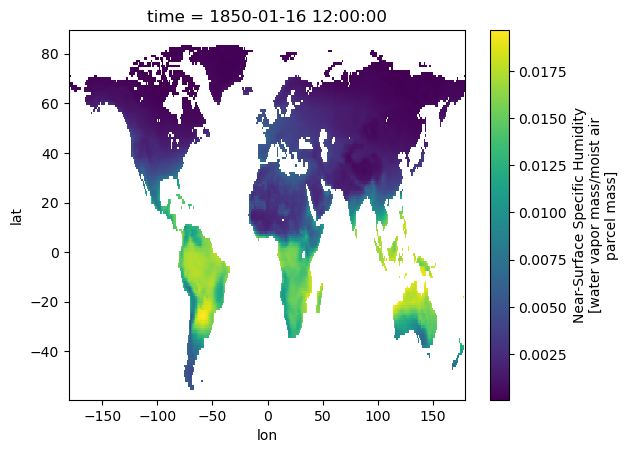

In [24]:
ds_dict[list(ds_dict.keys())[0]]['huss'].isel(time=0).plot()

In [25]:
for name, ds in ds_dict.items():
    ds = ds.drop(['huss','ps'])
    ds_dict[name] = ds

### 4. Save and replace netcdf files

In [27]:
# =========== Store file and remove any former one ==========
nc_out = save_file(ds_dict, folder=folder)

File with path: ../../data/CMIP6/ssp370/preprocessed/vpd/CMIP.TaiESM1.ssp370.vpd_regridded.nc saved
File with path: ../../data/CMIP6/ssp370/preprocessed/vpd/CMIP.BCC-CSM2-MR.ssp370.vpd_regridded.nc saved
File with path: ../../data/CMIP6/ssp370/preprocessed/vpd/CMIP.CanESM5.ssp370.vpd_regridded.nc saved
File with path: ../../data/CMIP6/ssp370/preprocessed/vpd/CMIP.CNRM-CM6-1.ssp370.vpd_regridded.nc saved
File with path: ../../data/CMIP6/ssp370/preprocessed/vpd/CMIP.CNRM-ESM2-1.ssp370.vpd_regridded.nc saved
File with path: ../../data/CMIP6/ssp370/preprocessed/vpd/CMIP.IPSL-CM6A-LR.ssp370.vpd_regridded.nc saved
File with path: ../../data/CMIP6/ssp370/preprocessed/vpd/CMIP.UKESM1-0-LL.ssp370.vpd_regridded.nc saved
File with path: ../../data/CMIP6/ssp370/preprocessed/vpd/CMIP.MPI-ESM1-2-LR.ssp370.vpd_regridded.nc saved
File with path: ../../data/CMIP6/ssp370/preprocessed/vpd/CMIP.CESM2-WACCM.ssp370.vpd_regridded.nc saved
File with path: ../../data/CMIP6/ssp370/preprocessed/vpd/CMIP.NorESM2-

In [ ]:
# =========== Check stored file ==============
xr.open_dataset(nc_out)